## Уровень 0:  Исследование данных и базовые методы обнаружения аномалий

### Цель :
- загрузить и иследовать (или сгенерить) простой датасет
- провести разведку (EDA)
- применить базовые статические методы для обнаружения аномалий
- визуализировать результаты

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

import warnings
from IPython.display import display


warnings.filterwarnings('ignore')
# Этот стиль добавляет сетку на фон и делает график matplotlib более читаемыми
plt.style.use('seaborn-v0_8-whitegrid')

## Функции

### подготовительные функции

In [2]:
# простенькая отрисовка
def scatterplot_X_and_y(x1, x2, y, title, xlabel, ylabel,
            fs=(6, 5), cmap='plasma', s=50, edg_c='k'):
    plt.figure(figsize=fs)
    plt.scatter(x1, x2, c=y, cmap=cmap, s=s, edgecolors=edg_c)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# генерация данных
def generate_data(n_samples=300, centers=1, cluster_std=1.0, random_state=42,
                  percentage_of_anomalies = 10, low=-10, high=10):
    
    np.random.seed(random_state)
    # генерация нормальных данных
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std,
                      random_state=random_state)
    # Добавление аномалий
    n_anomalies = n_samples * percentage_of_anomalies // 100
    anomalies = np.random.uniform(low=low, high=high, size=(n_anomalies, 2))
    X = np.vstack([X, anomalies])
    y = np.append(y, [-1]*n_anomalies)  # -1 = метка аномалии
    return X, y

# Создание DataFrame
def create_df(X, y):
    df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
    df['Label'] = y
    df['Is_Anomaly'] = df['Label'] == -1
    return df

# Основные статистики
def print_basic_statistics(df):
    print("Основные статистики:")
    display(df.describe().T)
    
    # Пропущенные значения
    print("\n" +"="*80)
    print("Пропущенных значений всего: ", df.isnull().sum().sum())
    
    # Распределение меток
    print("\n" + "="*80)
    print("Распределение меток:")
    display(df['Label'].value_counts())

# основные картинки
def basic_plots(df, f_1 = 'Feature_1', f_2 ='Feature_2'):
    # Гистограммы распределений
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(df[f_1], kde=True, bins=30)
    plt.title('Гистограмма Feature_1')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[f_2], kde=True, bins=30, color='orange')
    plt.title('Гистограмма Feature_2')
    plt.tight_layout()
    plt.show()
    
    # Boxplots
    plt.figure(figsize=(5, 3))
    sns.boxplot(df[[f_1, f_2]])
    plt.title('Boxplot Features')
    plt.show()


    print("\n" +"="*120)
    # Scatter plot с выделением аномалий чуть конкретнее  выделены аномалии
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df, 
        x= f_1, 
        y= f_2, 
        hue='Is_Anomaly',
        palette={True: 'red', False: 'blue'},
        style='Is_Anomaly',
        markers={True: 'X', False: 'o'},
        s=60
    )
    plt.title('Днные и аномалии')
    plt.legend(title='Аномалия')
    plt.show()
    

### функции анализа

In [3]:
# Метод Z-score
def detect_with_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))  # abs учитываем отклонения и в плюс и в минус
    return np.where(z_scores > threshold)


# Применение к признакам
def search_Z_score_anomalies(df, f_1 = 'Feature_1', f_2 ='Feature_2', threshold=3):
    anomalies_z_feat1 = detect_with_zscore(df[f_1], threshold)[0]
    anomalies_z_feat2 = detect_with_zscore(df[f_2], threshold)[0]
    all_z_anomalies = np.unique(np.concatenate((anomalies_z_feat1, anomalies_z_feat2)))
    df['Z_Score_Anomaly'] = False
    df.loc[all_z_anomalies, 'Z_Score_Anomaly'] = True
    
    print(f"Найдено аномалий по Z-score (Feature_1): {len(anomalies_z_feat1)}")
    print(f"Найдено аномалий по Z-score (Feature_2): {len(anomalies_z_feat2)}")
    print(f"Уникальных аномалий по Z-score: {len(all_z_anomalies)}")


# Метод IQR (Interquartile Range)
def detect_with_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)
    

# Применение
def search_IQR_anomalies(df, f_1 = 'Feature_1', f_2 ='Feature_2'):
    df['IQR_Anomaly_Feat_1'] = detect_with_iqr(df[f_1])
    df['IQR_Anomaly_Feat_2'] = detect_with_iqr(df[f_2])
    df['IQR_Anomaly'] = df['IQR_Anomaly_Feat_1'] | df['IQR_Anomaly_Feat_2']
    
    print(f"Найдено аномалий по IQR (Feature_1): {df['IQR_Anomaly_Feat_1'].sum()}")
    print(f"Найдено аномалий по IQR (Feature_2): {df['IQR_Anomaly_Feat_2'].sum()}")
    print(f"Уникальных аномалий по IQR: {df['IQR_Anomaly'].sum()}")


# отрисовква результата
def plot_results(df, f_1 = 'Feature_1', f_2 ='Feature_2'):
    plt.figure(figsize=(18, 12))
    
    # Исходные данные
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=df, x=f_1, y=f_2, hue='Is_Anomaly', 
                    palette={True: 'red', False: 'blue'})
    plt.title("Истинные аномалии")
    plt.grid(True)
    
    # Результаты Z-score
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df, x=f_1, y=f_2, hue='Z_Score_Anomaly', 
                    palette={True: 'red', False: 'blue'})
    plt.title("Обнаружение методом Z-score")
    plt.grid(True)
    
    # Результаты IQR
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x=f_1, y=f_2, hue='IQR_Anomaly', 
                    palette={True: 'red', False: 'blue'})
    plt.title("Обнаружение методом IQR")
    plt.grid(True)
    
    # Сравнение методов
    offset = 0.2
    plt.subplot(2, 2, 4)
    plt.scatter(df[f_1], df[f_2], c='gray', alpha=0.5, label='Нормальные')
    plt.scatter(df[df['Z_Score_Anomaly']][f_1] + offset, 
                df[df['Z_Score_Anomaly']][f_2] + offset, 
                c='blue', marker='s', label='Z-score')
    plt.scatter(df[df['IQR_Anomaly']][f_1] - offset, 
                df[df['IQR_Anomaly']][f_2] - offset, 
                c='green', marker='D', label='IQR')
    plt.scatter(df[df['Is_Anomaly']][f_1], 
                df[df['Is_Anomaly']][f_2], 
                c='red', marker='X', s=100, label='Истинные')
    
    plt.title("Сравнение методов")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



# общая оценка
def result_score(df):
    # Для Z-score
    print("="*50)
    print("Отчет для метода Z-score:")
    print(classification_report(df['Is_Anomaly'], df['Z_Score_Anomaly']))
    
    # Для IQR
    print("\n" + "="*50)
    print("Отчет для метода IQR:")
    print(classification_report(df['Is_Anomaly'], df['IQR_Anomaly']))

## 1. Данные имеют один кластер

### 1.2. Генерация тестовых данных 

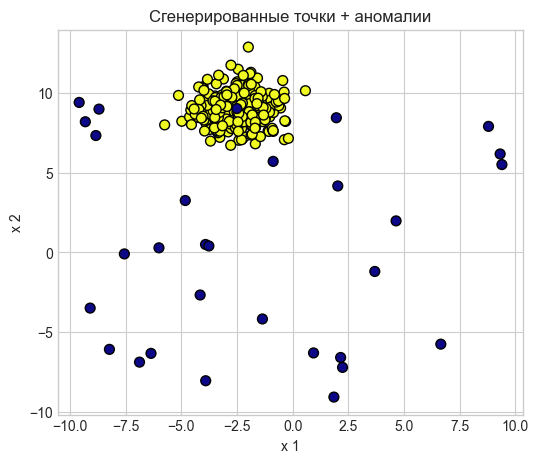

In [4]:
# Генерация данных
X, y = generate_data()

# Визуализация
scatterplot_X_and_y(X[:, 0], X[:, 1], y, "Сгенерированные точки + аномалии", "x 1", "x 2", )

In [5]:
# Создание DataFrame
df = create_df(X, y)
display(df.head(3))
df.tail(3)

,Feature_1,Feature_2,Label,Is_Anomaly
0,-2.182270,8.795186,0,False
1,-1.761904,9.624656,0,False
2,-3.110904,10.866564,0,False


,Feature_1,Feature_2,Label,Is_Anomaly
327,1.958000,8.437485,-1,True
328,-8.230150,-6.080343,-1,True
329,-9.095454,-3.493393,-1,True


### 1.3. Разведочный анализ данных (EDA)

In [6]:
# Основные статистики
print_basic_statistics(df)

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
Feature_1,330.0,-2.448507,2.006066,-9.588310,-3.271425,-2.474157,-1.835811,9.391693
Feature_2,330.0,8.217877,3.207515,-9.070992,8.154034,8.818020,9.576709,12.867018
Label,330.0,-0.090909,0.287916,-1.000000,0.000000,0.000000,0.000000,0.000000



Пропущенных значений всего:  0

Распределение меток:


Label
 0    300
-1     30
Name: count, dtype: int64

#### Визуализации

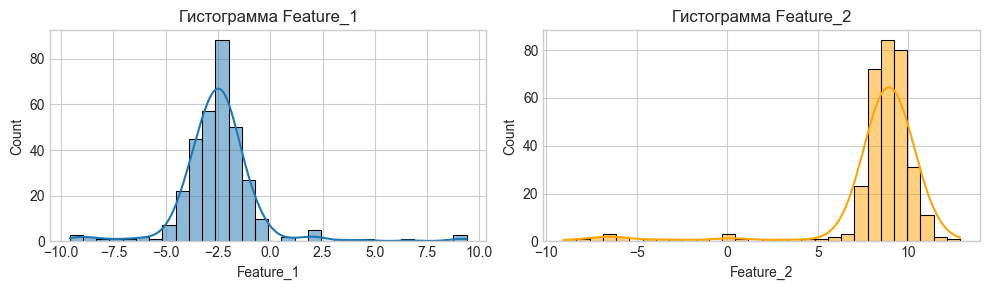

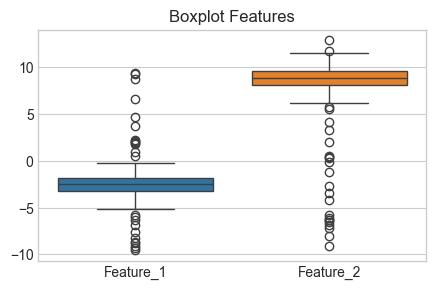

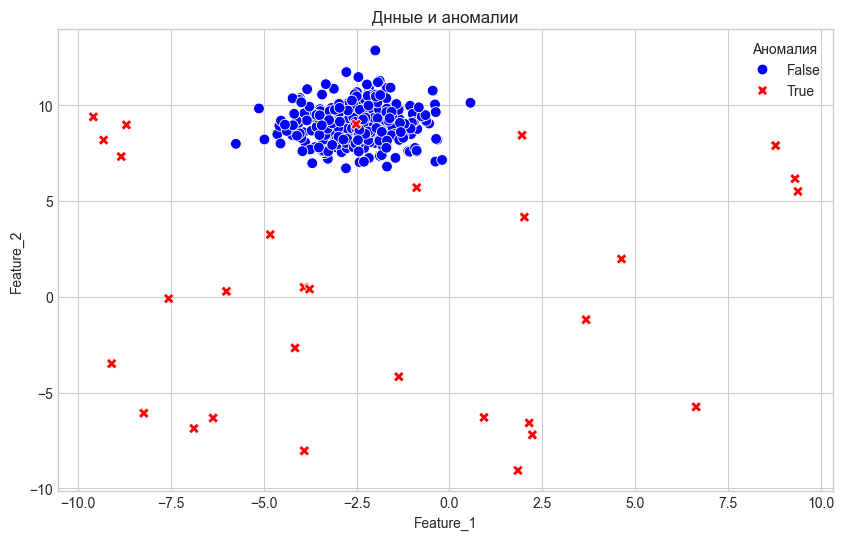

In [7]:
# основные картинки
basic_plots(df)

### 1.4. Статистические методы детекции

In [8]:
# Метод Z-score
search_Z_score_anomalies(df)

Найдено аномалий по Z-score (Feature_1): 11
Найдено аномалий по Z-score (Feature_2): 12
Уникальных аномалий по Z-score: 21


In [9]:
# Метод IQR (Interquartile Range)
search_IQR_anomalies(df)    

Найдено аномалий по IQR (Feature_1): 24
Найдено аномалий по IQR (Feature_2): 24
Уникальных аномалий по IQR: 33


### 1.5. Визуализация результатов

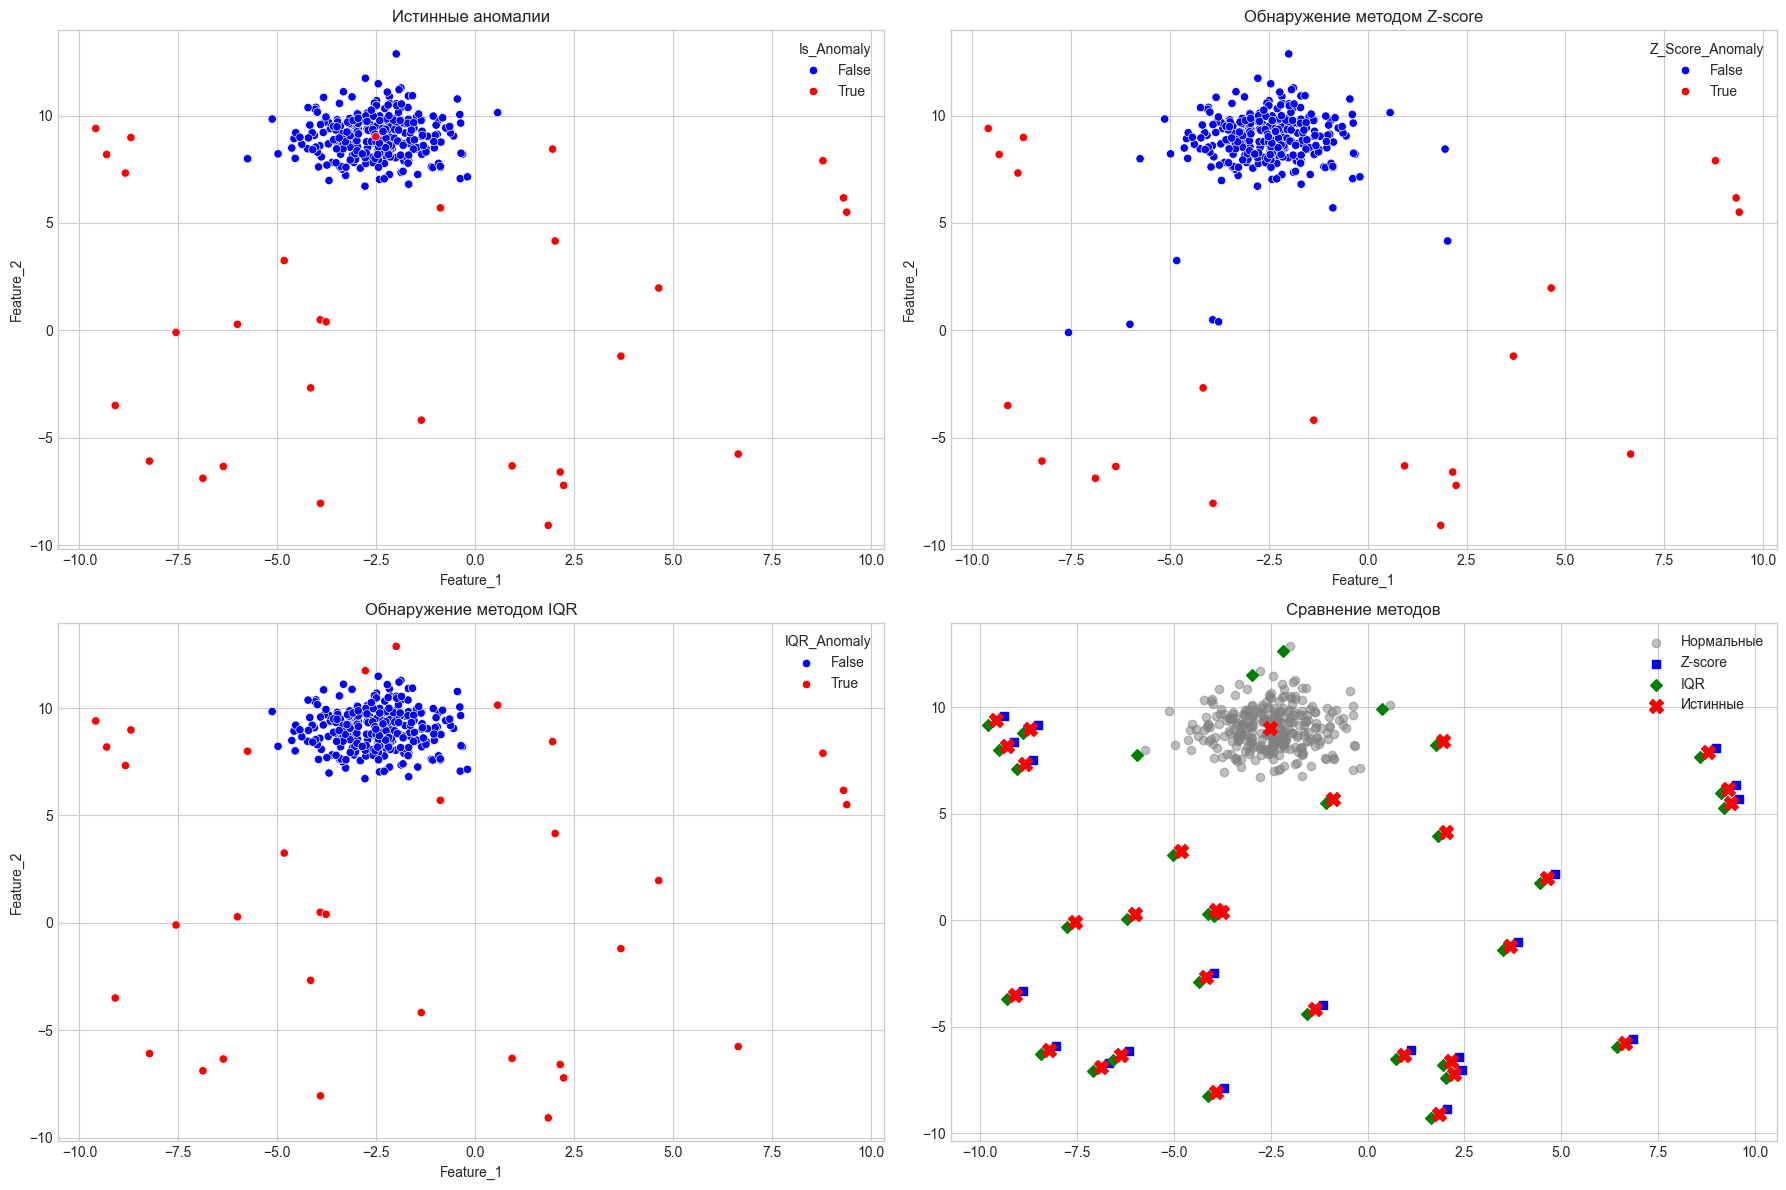

In [10]:

plot_results(df)

### 1.6. Оценка эффективности методов

In [11]:
result_score(df)

Отчет для метода Z-score:
              precision    recall  f1-score   support

       False       0.97      1.00      0.99       300
        True       1.00      0.70      0.82        30

    accuracy                           0.97       330
   macro avg       0.99      0.85      0.90       330
weighted avg       0.97      0.97      0.97       330


Отчет для метода IQR:
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       300
        True       0.88      0.97      0.92        30

    accuracy                           0.98       330
   macro avg       0.94      0.98      0.96       330
weighted avg       0.99      0.98      0.99       330



### 1.7 Вывод :

#### Z-score
- нет ложных срабатываний
- найдено только 70% аномалий
- общая точность(accuracy) = 0,97
#### IQR
- около  1 % ложных срабатываний
- найдено 97% аномалий
- общая точность(accuracy) = 0,98
#### Итого: 
- Z-score много пропущеных аномалий
- IQR более сбалансирован

## 2.Данные распределены по двум кластерам

### 2.2. Генерация тестовых данных 

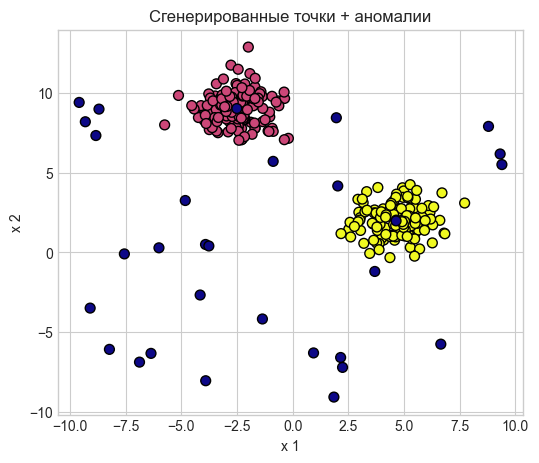

In [12]:
# Генерация данных
X, y = generate_data(centers=2)

# Визуализация
scatterplot_X_and_y(X[:, 0], X[:, 1], y, "Сгенерированные точки + аномалии", "x 1", "x 2", )

In [13]:
# Создание DataFrame
df_2 = create_df(X, y)
display(df_2.head(3))
df_2.tail(3)

,Feature_1,Feature_2,Label,Is_Anomaly
0,4.978375,1.557882,1,False
1,5.278471,0.311650,1,False
2,-2.522695,7.956575,0,False


,Feature_1,Feature_2,Label,Is_Anomaly
327,1.958000,8.437485,-1,True
328,-8.230150,-6.080343,-1,True
329,-9.095454,-3.493393,-1,True


### 2.3. Разведочный анализ данных (EDA)

In [14]:
# Основные статистики
print_basic_statistics(df_2)

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
Feature_1,330.0,0.801746,4.060928,-9.588310,-2.668108,-0.381603,4.662866,9.391693
Feature_2,330.0,5.016863,4.223543,-9.070992,1.668305,3.865963,8.971973,12.867018
Label,330.0,0.363636,0.643801,-1.000000,0.000000,0.000000,1.000000,1.000000



Пропущенных значений всего:  0

Распределение меток:


Label
 1    150
 0    150
-1     30
Name: count, dtype: int64

#### Визуализации

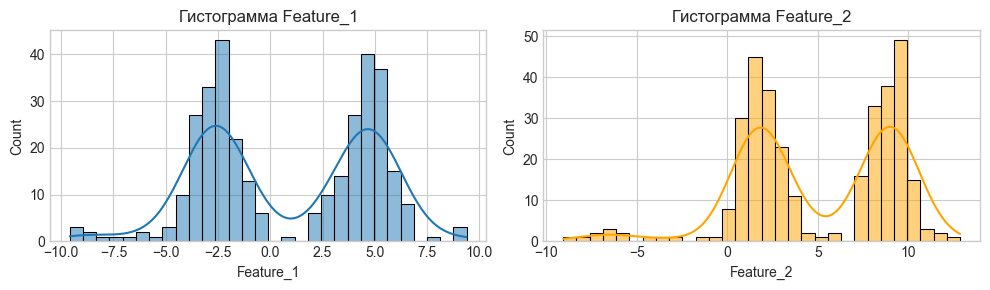

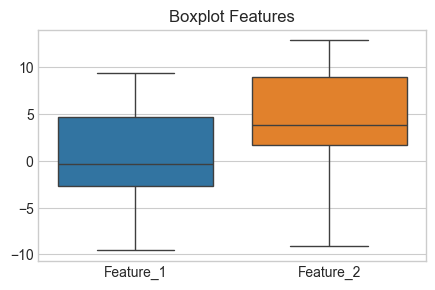

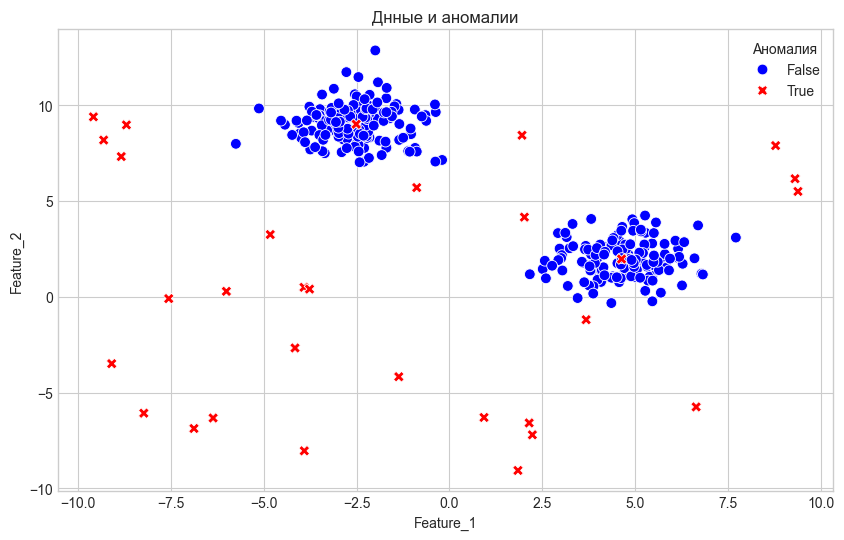

In [15]:
# основные картинки
basic_plots(df_2)

### 2.4. Статистические методы детекции

In [16]:
# Метод Z-score
search_Z_score_anomalies(df_2)
print('\n' + '='*40)
# Метод IQR (Interquartile Range)
search_IQR_anomalies(df_2)    

Найдено аномалий по Z-score (Feature_1): 0
Найдено аномалий по Z-score (Feature_2): 2
Уникальных аномалий по Z-score: 2

Найдено аномалий по IQR (Feature_1): 0
Найдено аномалий по IQR (Feature_2): 0
Уникальных аномалий по IQR: 0


### 2.5. Визуализация результатов

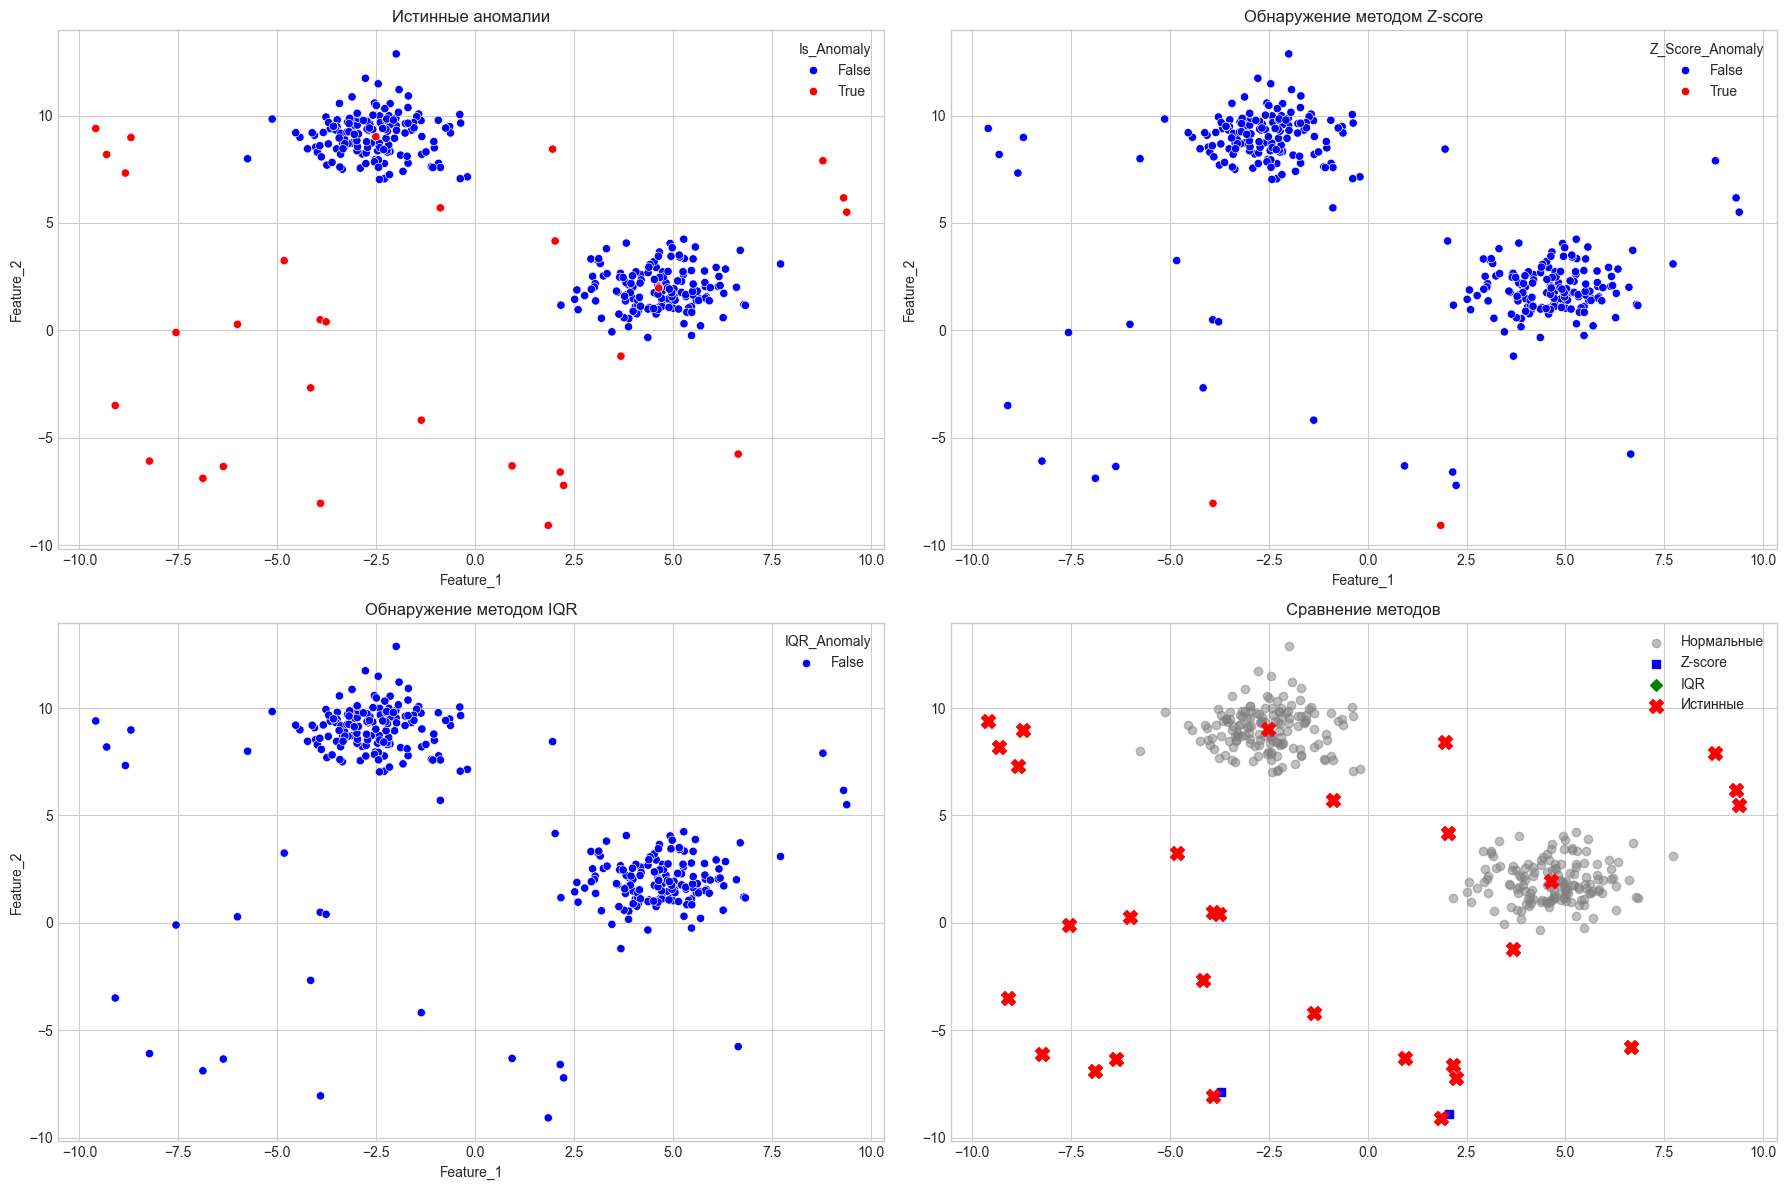

In [17]:
plot_results(df_2)

### 2.6. Оценка эффективности методов

In [18]:
result_score(df_2)

Отчет для метода Z-score:
              precision    recall  f1-score   support

       False       0.91      1.00      0.96       300
        True       1.00      0.07      0.12        30

    accuracy                           0.92       330
   macro avg       0.96      0.53      0.54       330
weighted avg       0.92      0.92      0.88       330


Отчет для метода IQR:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95       300
        True       0.00      0.00      0.00        30

    accuracy                           0.91       330
   macro avg       0.45      0.50      0.48       330
weighted avg       0.83      0.91      0.87       330



### 2.7 Вывод :

#### всё очень, очень, очень не хорошо....

## Итоговый Вывод:

### Краткий гид по Z-Score и IQR
#### Берём Z-Score, когда
- толпа точек близка к нормальной и ровной (распределение похоже к на колокол Гаусса, симметрично)
- аномалия - что-то очень далёкое от среднего показателя
- данных достаточно (от нескольких десятков)
- пример: Ошибки в процессе производства деталей (размеры обычно нормальны), время отклика сервера без сбоев.
#### Пользуем IQR (Межквартильный размах), когда:
- толпа неровная(перекос, тяжёлые хвосты)
- середина важнее среднего .)(эт про медиану...)
- пример: Зарплаты в компании (часто перекошены вправо), цены на жилье в городе, доходы клиентов, время решения сложных задач (некоторые "зависают")
#### Не стоит использовать :
- если аномалии – сложные комбинации признаков (многомерные данные), или данные имеют причудливую структуру (кластеры, неоднородности).

# Happy end...